<a href="https://colab.research.google.com/github/ledadu/deforum-stable-diffusion/blob/main/Deforum_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deforum Stable Diffusion v0.1**
[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team. [K Diffusion](https://github.com/crowsonkb/k-diffusion) by [Katherine Crowson](https://twitter.com/RiversHaveWings). You need to get the ckpt file and put it on your Google Drive first to use this. It can be downloaded from [HuggingFace](https://huggingface.co/CompVis/stable-diffusion).

Notebook by [deforum](https://discord.gg/upmXXsrwZc)

In [3]:
#@markdown **NVIDIA GPU**
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

Tesla P100-PCIE-16GB, 16280 MiB, 16280 MiB



In [4]:
#@markdown **Model Path Variables**
# ask for the link
print("Local Path Variables:\n")

models_path = "/content/models" #@param {type:"string"}
output_path = "/content/output" #@param {type:"string"}

#@markdown **Google Drive Path Variables (Optional)**
mount_google_drive = True #@param {type:"boolean"}
force_remount = False

if mount_google_drive:
    from google.colab import drive
    try:
        drive_path = "/content/drive"
        drive.mount(drive_path,force_remount=force_remount)
        models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
        output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
        models_path = models_path_gdrive
        output_path = output_path_gdrive
    except:
        print("...error mounting drive or with drive path variables")
        print("...reverting to default path variables")

import os
os.makedirs(models_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

print(f"models_path: {models_path}")
print(f"output_path: {output_path}")

Local Path Variables:

Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion


In [5]:
#@markdown **Setup Environment**

setup_environment = True #@param {type:"boolean"}
print_subprocess = False #@param {type:"boolean"}

if setup_environment:
    import subprocess
    print("...setting up environment")
    all_process = [['pip', 'install', 'torch==1.11.0+cu113', 'torchvision==0.12.0+cu113', 'torchaudio==0.11.0', '--extra-index-url', 'https://download.pytorch.org/whl/cu113'],
                   ['pip', 'install', 'omegaconf==2.1.1', 'einops==0.3.0', 'pytorch-lightning==1.4.2', 'torchmetrics==0.6.0', 'torchtext==0.2.3', 'transformers==4.19.2', 'kornia==0.6'],
                   ['git', 'clone', 'https://github.com/deforum/stable-diffusion'],
                   ['pip', 'install', '-e', 'git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers'],
                   ['pip', 'install', '-e', 'git+https://github.com/openai/CLIP.git@main#egg=clip'],
                   ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'resize-right', 'torchdiffeq'],
                 ]
    for process in all_process:
        running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
        if print_subprocess:
            print(running)
    
    print(subprocess.run(['git', 'clone', 'https://github.com/deforum/k-diffusion/'], stdout=subprocess.PIPE).stdout.decode('utf-8'))
    with open('k-diffusion/k_diffusion/__init__.py', 'w') as f:
        f.write('')

...setting up environment



In [6]:
#@markdown **Python Definitions**
import json
from IPython import display

import argparse, glob, os, pathlib, subprocess, sys, time
import cv2
import numpy as np
import pandas as pd
import random
import requests
import shutil
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from itertools import islice
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from skimage.exposure import match_histograms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from types import SimpleNamespace
from torch import autocast

sys.path.append('./src/taming-transformers')
sys.path.append('./src/clip')
sys.path.append('./stable-diffusion/')
sys.path.append('./k-diffusion')

from helpers import save_samples
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from k_diffusion import sampling
from k_diffusion.external import CompVisDenoiser

class CFGDenoiser(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.inner_model = model

    def forward(self, x, sigma, uncond, cond, cond_scale):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        cond_in = torch.cat([uncond, cond])
        uncond, cond = self.inner_model(x_in, sigma_in, cond=cond_in).chunk(2)
        return uncond + (cond - uncond) * cond_scale

def add_noise(sample: torch.Tensor, noise_amt: float):
    return sample + torch.randn(sample.shape, device=sample.device) * noise_amt

def get_output_folder(output_path,batch_folder=None):
    yearMonth = time.strftime('%Y-%m/')
    out_path = os.path.join(output_path,yearMonth)
    if batch_folder != "":
        out_path = os.path.join(out_path,batch_folder)
        # we will also make sure the path suffix is a slash if linux and a backslash if windows
        if out_path[-1] != os.path.sep:
            out_path += os.path.sep
    os.makedirs(out_path, exist_ok=True)
    return out_path

def load_img(path, shape):
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        image = Image.open(path).convert('RGB')

    image = image.resize(shape, resample=Image.LANCZOS)
    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

def maintain_colors(prev_img, color_match_sample, hsv=False):
    if hsv:
        prev_img_hsv = cv2.cvtColor(prev_img, cv2.COLOR_RGB2HSV)
        color_match_hsv = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2HSV)
        matched_hsv = match_histograms(prev_img_hsv, color_match_hsv, multichannel=True)
        return cv2.cvtColor(matched_hsv, cv2.COLOR_HSV2RGB)
    else:
        return match_histograms(prev_img, color_match_sample, multichannel=True)

def make_callback(sampler, dynamic_threshold=None, static_threshold=None):  
    # Creates the callback function to be passed into the samplers
    # The callback function is applied to the image after each step
    def dynamic_thresholding_(img, threshold):
        # Dynamic thresholding from Imagen paper (May 2022)
        s = np.percentile(np.abs(img.cpu()), threshold, axis=tuple(range(1,img.ndim)))
        s = np.max(np.append(s,1.0))
        torch.clamp_(img, -1*s, s)
        torch.FloatTensor.div_(img, s)

    # Callback for samplers in the k-diffusion repo, called thus:
    #   callback({'x': x, 'i': i, 'sigma': sigmas[i], 'sigma_hat': sigmas[i], 'denoised': denoised})
    def k_callback(args_dict):
        if static_threshold is not None:
            torch.clamp_(args_dict['x'], -1*static_threshold, static_threshold)
        if dynamic_threshold is not None:
            dynamic_thresholding_(args_dict['x'], dynamic_threshold)

    # Function that is called on the image (img) and step (i) at each step
    def img_callback(img, i):
        # Thresholding functions
        if dynamic_threshold is not None:
            dynamic_thresholding_(img, dynamic_threshold)
        if static_threshold is not None:
            torch.clamp_(img, -1*static_threshold, static_threshold)

    if sampler in ["plms","ddim"]: 
        # Callback function formated for compvis latent diffusion samplers
        callback = img_callback
    else: 
        # Default callback function uses k-diffusion sampler variables
        callback = k_callback

    return callback

def generate(args, return_latent=False, return_sample=False, return_c=False):
    seed_everything(args.seed)
    os.makedirs(args.outdir, exist_ok=True)

    if args.sampler == 'plms':
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    model_wrap = CompVisDenoiser(model)       
    batch_size = args.n_samples
    prompt = args.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]

    init_latent = None
    if args.init_latent is not None:
        init_latent = args.init_latent
    elif args.init_sample is not None:
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(args.init_sample))
    elif args.init_image != None and args.init_image != '':
        init_image = load_img(args.init_image, shape=(args.W, args.H)).to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space        

    sampler.make_schedule(ddim_num_steps=args.steps, ddim_eta=args.ddim_eta, verbose=False)

    t_enc = int((1.0-args.strength) * args.steps)

    start_code = None
    if args.fixed_code and init_latent == None:
        start_code = torch.randn([args.n_samples, args.C, args.H // args.f, args.W // args.f], device=device)

    callback = make_callback(sampler=args.sampler,
                            dynamic_threshold=args.dynamic_threshold, 
                            static_threshold=args.static_threshold)

    results = []
    precision_scope = autocast if args.precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for n in range(args.n_samples):
                    for prompts in data:
                        uc = None
                        if args.scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)

                        if args.init_c != None:
                          c = args.init_c

                        if args.sampler in ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral"]:
                            shape = [args.C, args.H // args.f, args.W // args.f]
                            sigmas = model_wrap.get_sigmas(args.steps)
                            if args.use_init:
                                sigmas = sigmas[len(sigmas)-t_enc-1:]
                                x = init_latent + torch.randn([args.n_samples, *shape], device=device) * sigmas[0]
                            else:
                                x = torch.randn([args.n_samples, *shape], device=device) * sigmas[0]
                            model_wrap_cfg = CFGDenoiser(model_wrap)
                            extra_args = {'cond': c, 'uncond': uc, 'cond_scale': args.scale}
                            if args.sampler=="klms":
                                samples = sampling.sample_lms(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                            elif args.sampler=="dpm2":
                                samples = sampling.sample_dpm_2(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                            elif args.sampler=="dpm2_ancestral":
                                samples = sampling.sample_dpm_2_ancestral(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                            elif args.sampler=="heun":
                                samples = sampling.sample_heun(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                            elif args.sampler=="euler":
                                samples = sampling.sample_euler(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                            elif args.sampler=="euler_ancestral":
                                samples = sampling.sample_euler_ancestral(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False, callback=callback)
                        else:

                            if init_latent != None:
                                z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                                samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=args.scale,
                                                        unconditional_conditioning=uc,)
                            else:
                                if args.sampler == 'plms' or args.sampler == 'ddim':
                                    shape = [args.C, args.H // args.f, args.W // args.f]
                                    samples, _ = sampler.sample(S=args.steps,
                                                                    conditioning=c,
                                                                    batch_size=args.n_samples,
                                                                    shape=shape,
                                                                    verbose=False,
                                                                    unconditional_guidance_scale=args.scale,
                                                                    unconditional_conditioning=uc,
                                                                    eta=args.ddim_eta,
                                                                    x_T=start_code,
                                                                    img_callback=callback)

                        if return_latent:
                            results.append(samples.clone())

                        x_samples = model.decode_first_stage(samples)
                        if return_sample:
                            results.append(x_samples.clone())

                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        if return_c:
                            results.append(c.clone())

                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            image = Image.fromarray(x_sample.astype(np.uint8))
                            results.append(image)
    return results

def sample_from_cv2(sample: np.ndarray) -> torch.Tensor:
    sample = ((sample.astype(float) / 255.0) * 2) - 1
    sample = sample[None].transpose(0, 3, 1, 2).astype(np.float16)
    sample = torch.from_numpy(sample)
    return sample

def sample_to_cv2(sample: torch.Tensor) -> np.ndarray:
    sample_f32 = rearrange(sample.squeeze().cpu().numpy(), "c h w -> h w c").astype(np.float32)
    sample_f32 = ((sample_f32 * 0.5) + 0.5).clip(0, 1)
    sample_int8 = (sample_f32 * 255).astype(np.uint8)
    return sample_int8

In [7]:

#@title Set functions

#@markdown conv dict to object
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

#@markdown conv arguments to dict
def createDict(*args):
     return dict(((k, eval(k)) for k in args))

#@markdown iterateFunction dict properties
def iterateFunction(function, opt, properties):
  from numpy import arange

  # Clone properties
  properties_copy = properties.copy()
  first_property = properties_copy.pop(0)
  first_property_name = first_property[0]
  first_property_values = first_property[1]
  print('first_property_values 1', first_property_values)
  # Manage string eval
  if isinstance(first_property_values, str):
      first_property_values = eval(first_property_values)
  print('first_property_values 2', first_property_values)
  #Loop values
  for value in first_property_values:
    # Upate the property value
    opt_copy = opt.copy()
    
    opt_copy[first_property_name] = value
    opt_copy['filename'] = f'{opt_copy["filename"]}-{value}'
    if len(properties_copy) == 0:
      function(opt_copy)
      continue
    # Go deep in iteration (next property)
    iterateFunction(function, opt=opt_copy, properties=properties_copy)

# TODO delete !!!!
def generateold(opt):
    prompt = opt['prompt']
    filename = "stable-difusion"
    height= 512
    width= 512
    guidance_scale= 7
    num_inference_steps= 50
    batch_size= 1
    seed = 6666
    progress_preview=  False
    progress_period=  10

    if opt['filename']: filename = opt['filename']
    if opt['height']: height = opt['height']
    if opt['width']: width = opt['width']
    if opt['guidance_scale']: guidance_scale = opt['guidance_scale']
    if opt['num_inference_steps']: num_inference_steps = opt['num_inference_steps']
    if opt['batch_size']: batch_size = opt['batch_size']
    if opt['seed']: seed = opt['seed']
    if opt['progress_preview']: progress_preview = opt['progress_preview']
    if opt['progress_period']: progress_period = opt['progress_period']

    print(f"Generate {filename} Seed : {seed} / scale: {guidance_scale} / steps: {num_inference_steps}")

    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise

    # ------------
    # First, we get the text_embeddings for the prompt. These embeddings will be used to condition the UNet model.

    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    # ------------
    # We'll also get the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token (empty text).
    # They need to have the same shape as the conditional text_embeddings (batch_size and seq_length)

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   

    # ------------

    # For classifier-free guidance, we need to do two forward passes. One with the conditioned input (text_embeddings), and another with the unconditional embeddings (uncond_embeddings).
    # In practice, we can concatenate both into a single batch to avoid doing two forward passes.
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # ------------
    # Generate the intial random noise.

    latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
    )
    latents = latents.to(torch_device)

    latents.shape
    # Cool  64×64  is expected. The model will transform this latent representation (pure noise) into a 512 × 512 image later on.

    # ------------
    # Next, we initialize the scheduler with our chosen num_inference_steps. This will compute the sigmas and exact time step values to be used during the denoising process.

    scheduler.set_timesteps(num_inference_steps)

    # ------------
    # The K-LMS scheduler needs to multiple the latents by its sigma values. Let's do this here

    latents = latents * scheduler.sigmas[0]


    # ------------
    # We are ready to write the denoising loop.

    from tqdm.auto import tqdm
    from tqdm import tqdm, trange
    from torch import autocast
    from PIL import Image

    progress_image = display(Image.new("RGB", (width, height), (255, 255, 255)), display_id=True)

    with autocast("cuda"):
      for i in trange(num_inference_steps, desc="Steps"):
      #for i in range(num_inference_steps):
        t = 1000 - 1000 * (i / (num_inference_steps-1) )       
        
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        # predict the noise residual
        with torch.no_grad():
          noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

        rest = i % progress_period
        if progress_preview and (rest == 0 or i == num_inference_steps - 1):
          temp_latents = 1 / 0.18215 * latents
          with torch.no_grad():
            temp_image = vae.decode(temp_latents)

          temp_image = (temp_image / 2 + 0.5).clamp(0, 1)
          temp_image = temp_image.detach().cpu().permute(0, 2, 3, 1).numpy()
          temp_images = (temp_image * 255).round().astype("uint8")
          temp_pil_images = [Image.fromarray(temp_image) for temp_image in temp_images]
          progress_image.update(temp_pil_images[0])

    # ------------
    # We now use the vae to decode the generated latents back into the image.
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
      image = vae.decode(latents)

    # ------------
    # Show image


    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]


    import piexif
    image_description = prompt.encode('utf8')

    zeroth_ifd = {
        piexif.ImageIFD.Artist: f'Scale: {guidance_scale} / Steps: {num_inference_steps}',
        piexif.ImageIFD.ImageDescription: image_description,
        piexif.ImageIFD.Copyright: f'Seed: {seed}',
        }
    exif_dict = {"0th": zeroth_ifd}
    exif_bytes = piexif.dump(exif_dict)

    pil_images[0].save(f'{filename}.jpg',  quality=100, subsampling=0, exif=exif_bytes)

    pil_images[0]
    
    return pil_images[0]

def process_noodle_soup(text_prompts):
  terms = []
  for term in terminology_database:
    if term not in terms:
      terms.append(term)

  prompt = text_prompts
  new_prompt = prompt
  for term in terms:
    tk = '_'+term+'_'
    tc = prompt.count(tk)
    for i in range(tc):
      new_prompt = new_prompt.replace(tk, random.choice(terminology_database[term]), 1)

  return new_prompt

In [8]:
#@title **The Pantry** (Terminology Database)
#@markdown #### <font color="orange">**NOTE:**</font> **Run the this cell to initialize the database.**

class log:
    f = lambda color: lambda string: print(color + string + "\33[0m")
    black = f("\33[30m")
    red = f("\33[31m")
    green = f("\33[32m")
    yellow = f("\33[33m")
    blue = f("\33[34m")
    megenta = f("\33[35m")
    cyan = f("\33[36m")
    white = f("\33[37m")

!wget -q --show-progress --no-cache --backups=1 'https://raw.githubusercontent.com/WASasquatch/noodle-soup-prompts/main/nsp_pantry.py'

import nsp_pantry
from nsp_pantry import nspterminology, nsp_parse

terminology_database = nspterminology

terminology_database['animal'] = ["Aardvark","Aardwolf","Abyssinian","Achrioptera Manga","Addax","Adelie Penguin","Aesculapian snake","Affenpinscher","Afghan Hound","African Bullfrog","African Bush Elephant","African Civet","African Clawed Frog","African Forest Elephant","African Golden Cat","African Grey Parrot","African Palm Civet","African Penguin","African Tree Toad","African Wild Dog","Agama Lizard","Aidi","Ainu","Airedale Terrier","Airedoodle","Akbash","Akita","Akita Shepherd","Alabai","Alaskan Husky","Alaskan Klee Kai","Alaskan Malamute","Alaskan Pollock","Alaskan Shepherd","Albacore Tuna","Albatross","Aldabra Giant Tortoise","Alligator Gar","Allosaurus","Alpaca","Alpine Dachsbracke","Alpine Goat","Alusky","Amargasaurus","Amazon Parrot","Amazon River Dolphin (Pink Dolphin)","Amazon Tree Boa","Ambrosia Beetle","American Alligator","American Alsatian","American Bulldog","American Cocker Spaniel","American Cockroach","American Coonhound","American Dog Tick","American Eskimo Dog","American Foxhound","American Hairless Terrier","American Leopard Hound","American Paddlefish","American Pit Bull Terrier","American Pygmy Goat","American Robin","American Staffordshire Terrier","American Toad","American Water Spaniel","American Wirehair Traits: What to Know Before You Buy","Amethystine Python (Scrub Python)","Amur Leopard","Anaconda","Anatolian Shepherd Dog","Anchovies","Angelfish","Angelshark","Anglerfish","Angora Ferret","Angora Goat","Anole Lizard","Anomalocaris","Ant","Antarctic scale worm","Anteater","Antelope","Ape","Appenzeller Dog","Apple Head Chihuahua","Apple Moth","Arabian Cobra","Arafura File Snake","Arapaima","Archaeopteryx","Archaeotherium","Archelon Turtle","Arctic Char","Arctic Fox","Arctic Hare","Arctic Wolf","Arctodus","Arctotherium","Arizona Bark Scorpion","Arizona Black Rattlesnake","Arizona Coral Snake","Armadillo","Armadillo Lizard","Armyworm","Aruba Rattlesnake","Asian Arowana","Asian Cockroach","Asian Elephant","Asian Giant Hornet","Asian Lady Beetle","Asian Palm Civet","Asian Vine Snake","Asiatic Black Bear","Asp","Assassin Bug","Atlantic Salmon","Atlas Moth","Aurochs","Aussiedoodle","Aussiedor","Australian Bulldog","Australian Cattle Dog","Australian Cockroach","Australian Flathead Perch","Australian Gecko","Australian Kelpie Dog","Australian Labradoodle","Australian Mist","Australian Retriever","Australian Shepherd","Australian Terrier","Australopithecus","Avocet","Axolotl","Aye Aye","Babirusa","Baboon","Bactrian Camel","Badger","Baiji","Baird’s Rat Snake","Bald Eagle","Baleen Whale","Balinese","Balkan Lynx","Ball Python","Bamboo Worms","Banana Ball Python","Banana Eel","Banana Spider","Banded Krait","Banded Palm Civet","Banded Water Snake","Bandicoot","Banjo Catfish","Barb","Barbet","Barn Owl","Barn Swallow","Barnacle","Barracuda","Barramundi Fish","Barred Owl","Basenji Dog","Basilisk Lizard","Basilosaurus","Basking Shark","Bassador","Basset Fauve de Bretagne","Basset Hound","Bassetoodle","Bat","Batfish","Bavarian Mountain Hound","Baya","Bea-Tzu","Beabull","Beagador","Beagle","Beagle Shepherd","Beaglier","Beago","Bear","Bearded Collie","Bearded Dragon","Bearded Vulture","Beaski","Beauceron","Beauty rat snake","Beaver","Bed Bugs","Bedlington Terrier","Bee","Beefalo","Beetle","Belgian Shepherd","Belgian Tervuren","Belted Kingfisher","Beluga Sturgeon","Bengal Tiger","Bergamasco","Berger Picard","Bernedoodle","Bernese Mountain Dog","Bernese Shepherd","Betta Fish (Siamese Fighting Fish)","Bichir","Bichon Frise","Bichpoo","Biewer Terrier","Bighorn Sheep","Bilby","Binturong","Bird","Bird Of Paradise","Bird Snake","Birman","Biscuit Beetle","Bismarck Ringed Python","Bison","Black And Tan Coonhound","Black Mamba","Black Marlin","Black Rat Snake","Black Rhinoceros","Black Russian Terrier","Black Wasp","Black Widow Spider","Black Witch Moth","Black-Capped Chickadee","Black-Footed Ferret","Black-headed python","Blacknose Shark","Blackpoll Warbler","Blacktip Reef Shark","Bladefin Basslet","Blanket Octopus","Blind Snake","Blister Beetle","Blobfish","Blood Python","Bloodhound","Blue Belly Lizard","Blue Catfish","Blue Eyed Pleco","Blue Gray Gnatcatcher","Blue grosbeak","Blue Iguana","Blue Jay","Blue Lacy Dog","Blue Picardy Spaniel","Blue Racer","Blue Shark","Blue Tit","Blue Whale","Blue-Ringed Octopus","Bluefin Tuna","Bluegill","Bluetick Coonhound","Boas","Bobcat","Bobolink","Boelen’s python","Boggle","Boglen Terrier","Boiga","Bolivian Anaconda","Bolognese Dog","Bombay","Bongo","Bonito Fish","Bonnethead Shark","Bonobo","Booby","Boomslang","Borador","Border Collie","Border Terrier","Bordoodle","Borkie","Bornean Orang-utan","Borneo Elephant","Boston Terrier","Bottlenose Dolphin","Bouvier Des Flandres","Bowfin","Bowhead Whale","Box Tree Moth","Box Turtle","Boxachi Dog Breed Complete Guide","Boxador","Boxer Dog","Boxerdoodle","Boxfish","Boxsky","Boxweiler","Boykin Spaniel","Brachiosaurus","Brahminy Blindsnake","Brazilian Terrier","Bredl’s Python","British Timber","Brittany","Brontosaurus","Bronze Whaler Shark","Brookesia Micra","Brown Bear","Brown Dog Tick","Brown Hyena","Brown Snake","Brown Water Snake","Brown-banded Cockroach","Brug","Brussels Griffon","Budgerigar","Buffalo","Bull Shark","Bull Terrier","Bull Trout","Bulldog","Bullfrog","Bullmastiff","Bullsnake","Bumblebee","Burmese","Burmese Python","Burrowing Frog","Burrowing Owl","Bush Baby","Bush Viper","Bushmaster Snake","Butterfly","Butterfly Fish","Cabbage Moth","Cactus Moth","Cactus Mouse","Caecilian","Caiman","Caiman Lizard","Cairn Terrier","California Kingsnake","Camel","Camel Cricket","Camel Spider","Canaan Dog","Canada Lynx","Canada Warbler","Canadian Eskimo Dog","Canadian Horse","Cane Corso","Cantil","Cape Lion","Capybara","Caracal","Caribbean Reef Shark","Caribou","Carolina Dog","Carolina Parakeet","Carp","Carpenter Ant","Carpet Python","Carpet Viper","Cascabel","Cashmere Goat","Cassowary","Cat","Cat Snake","Cat-Eyed Snake","Catahoula Leopard","Catalan Sheepdog","Caterpillar","Catfish","Cava Tzu","Cavador","Cavalier King Charles Spaniel","Cavapoo","Cave Bear","Cave Lion","Cecropia Moth","Centipede","Central Ranges Taipan","Ceratosaurus","Cesky Fousek","Cesky Terrier","Chameleon","Chamois","Chartreux","Cheagle","Checkered Garter Snake","Cheetah","Chesapeake Bay Retriever","Chickadee","Chicken","Chicken Snake","Chihuahua","Children’s python","Chimaera","Chimpanzee","Chinchilla","Chinese Alligator","Chinese Cobra","Chinese Crested Dog","Chinese Geese","Chinese Paddlefish","Chinese Shar-Pei","Chinook","Chinook Salmon","Chinstrap Penguin","Chipmunk","Chipoo","Chipping Sparrow","Chiweenie","Chorkie","Chow Chow","Chow Shepherd","Christmas Island Red Crab","Cicada","Cichlid","Cinereous Vulture","Cinnamon Ferret","Clothes Moth","Clouded Leopard","Clownfish","Clumber Spaniel","Coachwhip Snake","Coastal Carpet Python","Coastal Taipan","Coati","Cobia Fish","Cobras","Cockalier","Cockapoo","Cockatiel","Cockatoo","Cocker Spaniel","Cockroach","Codfish","Codling Moth","Coelacanth","Collared Peccary","Collett’s Snake","Collie","Colossal Squid","Comet Moth","Common Buzzard","Common Carp","Common European Adder","Common Frog","Common Furniture Beetle","Common House Spider","Common Loon","Common Raven","Common Toad","Compsognathus","Conger Eel","Congo Snake","Cookiecutter Shark","Cooper’s Hawk","Copperhead","Coral","Coral Snake","Corgidor","Corgipoo","Corkie","Corman Shepherd","Corn Rex Cat (Cornish Rex)","Corn Snake","Cory Catfish","Coton de Tulear","Cotton-top Tamarin","Cottonmouth","Cougar","Cow","Coyote","Crab","Crab Spider","Crab-Eating Macaque","Crabeater Seal","Crane","Crappie Fish","Crested Gecko","Crested Penguin","Cricket","Crocodile","Crocodile Monitor","Cross Fox","Cross River Gorilla","Crow","Crucian Carp","Cuban Boa","Cuban Cockroach","Cuckoo","Curly Coated Retriever","Cuscus","Cuttlefish","Czechoslovakian Wolfdog","Dachsador","Dachshund","Daeodon","Dalmadoodle","Dalmador","Dalmatian","Danios","Dapple Dachshund","Dark-Eyed Junco","Darwin’s fox","Darwin’s Frog","Death Adder","Death’s Head Cockroach","Deathwatch Beetle","Deer","Deer Head Chihuahua","Deer Tick","Desert Kingsnake","Desert Locust","Desert Rain Frog","Desert Tortoise","Deutsche Bracke","Devils Coach Horse Beetle","Devon Rex","Dhole","Diamond python","Diamondback Moth","Dik-Dik","Dingo","Diplodocus","Dire Wolf","Discus","Doberman Pinscher","Dodo","Dog","Dog Tick","Dogo Argentino","Dogue De Bordeaux","Dolphin","Donkey","Dorgi","Dorkie","Dormouse","Double Doodle","Douc","Downy Woodpecker","Doxiepoo","Doxle","Draco Volans Lizard","Dragonfish","Dragonfly","Dreadnoughtus","Drever","Drum Fish","Dubia Cockroach","Duck","Dugong","Dumeril’s Boa","Dung Beetle","Dunker","Dunnock","Dusky Dolphin","Dusky Shark","Dwarf Boa","Dwarf Crocodile","Dwarf Hamster","Eagle","Earthworm","Earwig","Eastern Barred Bandicoot","Eastern Bluebird","Eastern Brown Snake","Eastern Chipmunk","Eastern Coral Snake","Eastern Diamondback Rattlesnake","Eastern Fence Lizard","Eastern Glass Lizard","Eastern Gorilla","Eastern Gray Squirrel","Eastern Green Mamba","Eastern Hognose Snake","Eastern Indigo Snake","Eastern Lowland Gorilla","Eastern Phoebe","Eastern Racer","Eastern Rat snake","Eastern Woodrat","Echidna","Eclectus Parrot","Edible Frog","Eel","Egyptian Cobra (Egyptian Asp)","Egyptian Goose","Egyptian Mau","Eland","Elasmosaurus","Elasmotherium","Electric Catfish","Electric Eel","Elegant Tern","Elephant","Elephant Seal","Elephant Shrew","Elk","Emerald Tree Boa","Emerald Tree Monitor","Emperor Penguin","Emperor Tamarin","Emu","English Bulldog","English Cocker Spaniel","English Cream Golden Retriever","English Foxhound","English Pointer","English Setter","English Shepherd","English Springer Spaniel","Entlebucher Mountain Dog","Epagneul Pont Audemer","Equatorial Spitting Cobra","Ermine","Escolar","Eskimo Dog","Eskipoo","Estrela Mountain Dog","Eurasian Beaver","Eurasian Jay","Eurasian Lynx","Eurasian Nuthatch","Eurasian Wolf","European Bee-Eater","European Corn Borer","European Polecat","European Robin","European Starling","European Wildcat","Evening Bat","Eyelash Viper","Falcon","Fallow deer","False Cobra","False coral snake","False Killer Whale","False Water Cobra","False Widow Spider","Fangtooth","Feist","Fennec Fox","Fer-de-lance Snake","Ferret","Ferruginous Hawk","Fiddler Crab","Field Spaniel","Fierce Snake","Fila Brasileiro","Fin Whale","Finnish Spitz","Fire Eel","Fire salamander","Fire-Bellied Toad","Firefly","Fish","Fisher Cat","Fishing Cat","Flamingo","Flat-Coated Retriever","Flea","Florida Gar","Florida Panther","Florida Woods Cockroach","Flounder","Flowerhorn Fish","Fluke Fish (summer flounder)","Fly","Flying Fish","Flying Lemur","Flying Snake","Flying Squirrel","Football Fish","Forest Cobra","Formosan Mountain Dog","Fossa","Fox","Fox Snakes","Fox Squirrel","Fox Terrier","French Bulldog","Frenchton","Frengle","Freshwater Crocodile","Freshwater Eel","Freshwater Jellyfish","Frigatebird","Frilled Lizard","Frilled Shark","Frog","Frogfish","Fruit Bat","Fruit Fly","Fur Seal","Gaboon Viper","Galapagos Penguin","Galapagos Shark","Galapagos Tortoise","Gar","Garden Eel","Gargoyle Gecko","Garter Snake","Gazelle","Gecko","Genet","Gentoo Penguin","Geoffroys Tamarin","Gerberian Shepsky","Gerbil","German Cockroach","German Pinscher","German Shepherd Guide","German Sheppit","German Sheprador","German Shorthaired Pointer","German Spitz","Gharial","Ghost Catfish","Ghost Crab","Giant African Land Snail","Giant Armadillo","Giant Clam","Giant Desert Centipede","Giant Leopard Moth","Giant Panda Bear","Giant Salamander","Giant Schnauzer","Giant Schnoodle","Giant Weta","Gibbon","Gila Monster","Giraffe","Glass Frog","Glass Lizard","Glechon","Glen Of Imaal Terrier","Glow Worm","Gnat","Goat","Goberian","Goblin Shark","Goby Fish","Goldador","Golden Dox","Golden Lancehead","Golden Lion Tamarin","Golden Masked Owl","Golden Newfie","Golden Oriole","Golden Pyrenees","Golden Retriever","Golden Saint","Golden Shepherd","Golden-Crowned Flying Fox","Goldendoodle","Goldfish","Goliath Beetle","Goliath Frog","Goliath Tigerfish","Gomphotherium","Goonch Catfish","Goose","Gopher","Gopher Snake","Gopher Tortoise","Gordon Setter","Gorilla","Goshawk","Gouldian Finch","Grass Carp","Grass Snake","Grasshopper","Grasshopper Mouse","Gray Fox","Gray Tree Frog","Great Blue Heron","Great Crested Flycatcher","Great Dane","Great Danoodle","Great Egret","Great Hammerhead Shark","Great Plains Rat Snake","Great Pyrenees","Great White Shark","Greater Swiss Mountain Dog","Green Anaconda","Green Anole","Green Aphids","Green Bee-Eater","Green Frog","Green Heron","Green Mamba","Green Rat Snake","Green Snake","Green Tree Frog","Green Tree Python","Greenland Dog","Greenland Shark","Grey Heron","Grey Mouse Lemur","Grey Reef Shark","Grey Seal","Greyhound","Griffon Vulture","Griffonshire","Grizzly Bear","Groenendael","Ground Snake","Groundhog (Woodchuck)","Grouper","Grouse","Guinea Fowl","Guinea Pig","Guppy","Habu Snake","Haddock","Hagfish","Halibut","Hamburg Chicken","Hammerhead Shark","Hamster","Harbor Seal","Hardhead Catfish","Hare","Harlequin Snake","Harp Seal","Harpy Eagle","Harrier","Harris Hawk","Havanese","Havapoo","Havashire","Hawaiian Crow","Hawaiian Goose","Hawaiian Monk Seal","Hawk Moth Caterpillar","Hedgehog","Hellbender","Hercules Beetle","Hercules Moth","Hermit Crab","Heron","Herring","Highland Cattle","Himalayan","Hippopotamus","Hoary Bat","Hobo Spider","Hognose snake","Hokkaido","Honduran White Bat","Honey Badger","Honey Bee","Honey Buzzard","Hooded Oriole","Hooded Seal","Hook-Nosed Sea Snake","Hoopoe","Horgi","Horn Shark","Hornbill","Horned Adder","Horned Frog","Horned Lizard","Horned Viper","Horse","Horsefly","Horseshoe Crab","House Finch","House Sparrow","House wren","Housefly","Howler Monkey","Human","Humboldt Penguin","Humboldt Squid","Hummingbird","Hummingbird Hawk-Moth","Humpback Whale","Huntaway","Huntsman Spider","Huskador","Huskita","Husky","Husky Jack","Huskydoodle","Hyaenodon","Hyena","Ibex","Ibis","Ibizan Hound","Icelandic Sheepdog","Ichthyosaurus","Iguana","Iguanodon","Immortal Jellyfish","Impala","Imperial Moth","Indian Cobra","Indian Elephant","Indian Giant Squirrel","Indian Palm Squirrel","Indian python","Indian Rhinoceros","Indian Star Tortoise","Indianmeal Moth","Indigo Snake","Indochinese Tiger","Indri","Inland Taipan","Insect","Insects","Irish Doodle","Irish Setter","Irish Terrier","Irish Water Spaniel","Irish WolfHound","Italian Greyhound","Ivory-billed woodpecker","Jacana","Jack Russell","Jackabee","Jackal","Jackdaw","Jackrabbit","Jackson’s Chameleon","Jaguar","Jaguarundi Cat","Jamaican Boa","Japanese Beetle","Japanese Chin","Japanese Macaque","Japanese rat snake","Japanese Spitz","Japanese Squirrel","Japanese Terrier","Javan Rhinoceros","Javanese","Jellyfish","Jerboa","Jewel Beetle ","Jonah Crab","Joro Spider","Jumping Spider","Jungle Carpet Python","Junglefowl","Kai Ken","Kakapo","Kangal","Kangaroo","Kangaroo Rat","Keel-Billed Toucan","Keelback","Keeshond","Kenyan Sand Boa","Kerry Blue Terrier","Kestrel","Keta Salmon","Key Deer","Kiko Goat","Killdeer","Killer Whale","Kinabalu Giant Red Leech","Kinder Goat","King Cobra","King Crab","King Penguin","King Rat Snake","King Shepherd","King Snake","King Vulture","Kingfisher","Kinkajou","Kirtland’s snake","Kishu","Kit Fox","Kitefin Shark","Kiwi","Klipspringer","Koala","Kodkod","Koi Fish","Komodo Dragon","Kooikerhondje","Kookaburra","Koolie","Kori Bustard","Krait","Krill","Kudu","Kuvasz","Labahoula","Labmaraner","Labradane","Labradoodle","Labrador Retriever","Labraheeler","Ladybug","Lake Sturgeon","Lakeland Terrier","LaMancha Goat","Lamprey","Lancashire Heeler","Lappet-faced Vulture","Lapponian Herder","Lavender Albino Ball Python","Lawnmower Blenny","Lazarus Lizard","Leaf-Tailed Gecko","Leatherback Sea Turtle","Leech","Lemming","Lemon Shark","Lemur","Leonberger","Leopard","Leopard Cat","Leopard Frog","Leopard Gecko","Leopard Lizard","Leopard Seal","Leopard Shark","Leopard Tortoise","Lhasa Apso","Lhasapoo","Liger","Lion","Lion’s Mane Jellyfish","Lionfish","Little Brown Bat","Little Penguin","Livyatan","Lizard","Lizardfish","Llama","Loach","Lobster","Locust","Lone Star Tick","Long-Eared Owl","Long-Haired Rottweiler","Long-Tailed Tit","Longfin Mako Shark","Longnose Gar","Lorikeet","Lowchen","Lumpfish","Lungfish","Lynx","Lyrebird","Macaque","Macaroni Penguin","Macaw","Machaeroides","Mackenzie Wolf","Madagascar Hissing Cockroach","Madagascar Tree Boa","Magellanic Penguin","Maggot","Magpie","Mahi Mahi (Dolphin Fish)","Maiasaura","Maine Coon","Malayan Civet","Malayan Krait","Malayan Tiger","Malchi","Mallard","Malteagle","Maltese","Maltese Shih Tzu","Maltipoo","Mamba","Mamushi Snake","Man of War Jellyfish","Manatee","Manchester Terrier","Mandarin Rat Snake","Mandrill","Maned Wolf","Mangrove Snake","Manta Ray","Mantella Frog","Marabou Stork","Marble Fox","Marine Iguana","Marine Toad","Markhor","Marmoset","Marmot","Marsh Frog","Masked Angelfish","Masked Palm Civet","Massasauga","Mastador","Mastiff","Mayfly","Meagle","Mealybug","Meerkat","Megalania","Megalodon","Megamouth Shark","Megatherium","Mekong Giant Catfish","Mexican Alligator Lizard","Mexican Black Kingsnake","Mexican Eagle (Northern crested caracara)","Mexican Free-Tailed Bat","Mexican Mole Lizard","Microraptor","Midget Faded Rattlesnake","Miki","Milk Snake","Milkfish","Millipede","Mini Labradoodle","Miniature Bull Terrier","Miniature Husky","Miniature Pinscher","Mink","Minke Whale","Mississippi Kite","Moccasin Snake","Mojarra","Mojave Rattlesnake","Mola mola (Ocean Sunfish)","Mole","Mole Cricket","Mole Snake","Molly","Monarch Butterfly","Mongoose","Mongrel","Monitor Lizard","Monkey","Monkfish","Monocled Cobra","Monte Iberia Eleuth","Moon Jellyfish","Moorhen","Moose","Moray Eel","Morkie","Mosasaurus","Moscow Watchdog","Mosquito","Moth","Mountain Bluebird","Mountain Cur","Mountain Feist","Mountain Gorilla","Mountain Lion","Mourning Dove","Mouse","Mozambique Spitting Cobra","Mud Snake","Mudi","Mudpuppy","Mule","Mulga Snake","Muntjac","Muskox","Muskrat","Mussurana Snake","Muttaburrasaurus","Myna Bird","Naked Mole Rat","Narwhal","Natterjack","Neanderthal","Neapolitan Mastiff","Nebelung","Needlefish","Neon Tetra","Neptune Grouper","Newfoundland","Newfypoo","Newt","Nicobar pigeon","Nigerian Goat","Night Adder","Night Heron","Night Snake","Nightingale","Nile Crocodile","Nilgai","No See Ums","Norfolk Terrier","North American Black Bear","Northern Alligator Lizard","Northern Cardinal","Northern Flicker","Northern Fur Seal","Northern Inuit Dog","Northern Water Snake","Norwegian Buhund","Norwegian Elkhound","Norwegian Forest","Norwegian Lundehund","Norwich Terrier","Nose-horned viper","Nova Scotia Duck Tolling Retriever","Nubian Goat","Nudibranch","Numbat","Nurse Shark","Nyala","Oak Toad","Oceanic Whitetip Shark","Ocelot","Octopus","Oenpelli python","Okapi","Old English Sheepdog","Olive Baboon","Olive python","Olive Sea Snake","Olm","Opah","Opossum","Orang-utan","Orange-Crowned Warbler","Orb Weaver","Ornithomimus","Ortolan Bunting","Oscar Fish","Ostrich","Otter","Otterhound","Oviraptor","Owl","Ox","Oyster","Oyster Toadfish","Pacific Sleeper Shark","Paddlefish","Pademelon","Painted Turtle","Pangolin","Panther","Papillon","Paradise Flying Snake","Parakeet","Parasaurolophus","Parrot","Parrot Snake","Parrotfish","Parrotlet","Parson Russell Terrier","Patagotitan","Patas Monkey","Patterdale Terrier","Pea Puffer","Peacock","Peacock Butterfly","Peacock Spider","Peagle","Peekapoo","Pekingese","Pelican","Pembroke Welsh Corgi","Penguin","Pennsylvania Wood Cockroach","Peppered Moth","Peppermint Angelfish","Pere Davids Deer","Peregrine Falcon","Peringuey’s Adder","Perro De Presa Canario","Persian","Peruvian Inca Orchid","Pesquet’s Parrot (Dracula Parrot)","Petit Basset Griffon Vendéen","Petite Goldendoodle","Pheasant","Philippine Cobra","Phorusrhacos","Pied Ball Python","Pied Tamarin","Pig","Pigeon","Pika","Pike Fish","Pileated Woodpecker","Pine Marten","Pine Snake","Pine Snake","Pink Fairy Armadillo","Pipe Snake","Pipefish","Piranha","Pit Bull","Pit Viper","Pitador","Pitsky","Plains Hognose Snake","Platinum Arowana","Platybelodon","Platypus","Pocket Beagle","Pocket Pitbull","Pointer","Poison Dart Frog","Polar Bear","Polecat","Polish Lowland Sheepdog","Polka Dot Stingray","Polyphemus moth","Pomapoo","Pomchi","Pomeagle","Pomeranian","Pomsky","Pond Skater","Poochon","Poodle","Poogle","Pool Frog","Porbeagle Shark","Porcupine","Porpoise","Possum","Potoo","Potoroo","Prairie Dog","Prairie Rattlesnake","Prawn","Praying Mantis","Proboscis Monkey","Procoptodon","Pronghorn","Psittacosaurus","Pteranodon","Pterodactyl","Pudelpointer","Puff Adder","Pufferfish","Puffin","Pug","Pugapoo","Puggle","Pugshire","Puma","Pumi","Purple Emperor Butterfly","Purple Finch","Puss Moth","Pygmy Hippopotamus","Pygmy Marmoset (Finger Monkey)","Pygmy python","Pygmy Shark","Pygora Goat","Pyjama Shark","Pyrador","Pyredoodle","Python","Quagga","Quail","Queen snake","Quetzal","Quokka","Quoll","Rabbit","Raccoon","Raccoon Dog","Racer Snake","Radiated Tortoise","Ragamuffin","Ragdoll","Raggle","Rainbow Boa","Rainbow Shark","Rat","Rat Snakes","Rat Terrier","Rattlesnake","Red Diamondback Rattlesnake","Red Finch","Red Fox","Red Kite","Red Knee Tarantula","Red Panda","Red Racer Snake","Red Spitting Cobra","Red Squirrel","Red Tail Boa (common boa)","Red Wolf","Red-Bellied Black Snake","Red-Billed Quelea Bird","Red-Eared Slider","Red-Eyed Tree Frog","Red-Footed Tortoise","Red-handed Tamarin","Red-Headed Vulture","Red-Lipped Batfish","Red-winged blackbird","Redback Spider","Redbone Coonhound","Redtail Catfish","Reef Shark","Reindeer","Repenomamus","Reticulated python","Rhino Viper","Rhinoceros","Rhombic Egg-Eater Snake","Ribbon Eel","Ribbon Snake","Ring-billed Gull","Ringed Kingfisher","Rinkhals Snake","River Otter","River Turtle","Robin","Rock Crab","Rock Hyrax","Rock Python","Rockfish","Rockhopper Penguin","Rodents","Roe Deer","Rooster","Rose-breasted Grosbeak","Roseate Spoonbill","Rosy Boa","Rottsky","Rottweiler","Rough Green Snake","Royal Penguin","Rubber Boa","Ruby-Throated Hummingbird","Ruddy Turnstone","Russel’s Viper","Russell Terrier","Russian Bear Dog","Russian Blue","Russian Tortoise","Saanen Goat","Saarloos Wolfdog","Saber-Toothed Tiger","Sable","Sable Black German Shepherd","Sable Ferret","Saiga","Saint Berdoodle","Saint Bernard","Saint Shepherd","Salamander","Salmon","Salmon Shark","Saluki","Sambar","Samoyed","San Francisco Garter Snake","Sand Crab","Sand Lizard","Sand Tiger Shark","Sand Viper","Sandhill Crane","Saola","Sardines","Satanic leaf-tailed gecko","Sauropoda","Savanna Goat","Savannah Sparrow","Savu Python","Saw-scaled viper","Sawfish","Scarab Beetle","Scarlet Kingsnake","Scarlet Macaw","Schipperke","Schneagle","Schnoodle","Scimitar-horned Oryx","Scorpion","Scorpion Fish","Scottish Terrier","Scrotum Frog","Sculpin","Sea Anemone","Sea Dragon","Sea Eagle","Sea Lion","Sea Otter","Sea Roach","Sea Slug","Sea Squirt","Sea Turtle","Sea Urchin","Seagull","Seahorse","Seal","Sealyham Terrier","Sei Whale","Senegal Parrot","Serval","Shark","Sharp-Tailed Snake","Sheep","Sheepadoodle","Shepadoodle","Shepkita","Shepweiler","Shiba Inu","Shih Poo","Shih Tzu","Shoebill Stork","Shollie","Short-Faced Bear","Shortfin Mako Shark","Shrew","Shrimp","Siamese","Siberian","Siberian Husky","Siberian Ibex","Siberian Retriever","Siberian Tiger","Siberpoo","Sidewinder","Silkie Chicken","Silky Shark","Silky Terrier","Silver Dollar","Silver Labrador","Sinosauropteryx","Sixgill shark","Skate Fish","Skink Lizard","Skipjack Tuna","Skunk","Skye Terrier","Sleeper Shark","Sloth","Slow Worm","Slug","Smokybrown Cockroach","Smooth Fox Terrier","Smooth Green Snake","Smooth Snake","Snail","Snake","Snapping Turtle","Snook Fish","Snorkie","Snouted Cobra","Snow Crab","Snow Leopard","Snowberry Clearwing Moth","Snowshoe","Snowshoe Hare","Snowy Owl","Sockeye Salmon","Somali","Song Sparrow","Song Thrush","South China Tiger","Southern Black Racer","Southern Hognose Snake","Southern Pacific Rattlesnake","Spadefoot Toad","Spanador","Spanish Goat","Spanish Mastiff","Sparrow","Sparrowhawk","Speckled Kingsnake","Spectacled Bear","Sperm Whale","Sphynx Traits: What to Know Before You Buy","Spider","Spider Ball Python","Spider Monkey","Spider Wasp","Spider-Tailed Horned Viper","Spinner Shark","Spinone Italiano","Spinosaurus","Spiny bush viper","Spiny Dogfish","Spiny Hill Turtle","Spitting Cobra","Spixs Macaw","Sponge","Spotted Gar","Spotted Lanternfly","Spotted python","Springador","Springbok","Springerdoodle","Squash Beetle","Squid","Squirrel","Squirrel Monkey","Squirrelfish","Sri Lankan Elephant","Stabyhoun","Staffordshire Bull Terrier","Stag Beetle","Standard Schnauzer","Star-nosed mole","Starfish","Stargazer Fish","Steelhead Salmon","Steller’s Sea Cow","Stick Insect","Stiletto Snake","Stingray","Stoat","Stone Crab","Stork","Striped Hyena","Striped Rocket Frog","Sturgeon","Styracosaurus","Suchomimus","Sucker Fish","Sugar Glider","Sulcata Tortoise","Sumatran Elephant","Sumatran Orang-utan","Sumatran Rhinoceros","Sumatran Tiger","Sun Bear","Sunbeam Snake","Surgeonfish","Swai Fish","Swan","Swedish Vallhund","Syrian Hamster","Taco Terrier","Taipan","Takin","Tamaskan","Tang","Tapanuli Orang-utan","Tapir","Tarantula Hawk","Tarbosaurus","Tarpon","Tarsier","Tasmanian Devil","Tasmanian Tiger","Tawny Owl","Teddy Bear Hamster","Teddy Roosevelt Terrier","Telescope Fish","Tennessee Walking Horse","Tentacled Snake","Tenterfield Terrier","Termite","Terrier","Terror Bird","Tetra","Texas Blind Snake","Texas Coral Snake","Texas Garter Snake","Texas Heeler","Texas Indigo Snake","Texas Night Snake","Texas Rat Snake","Texas Spiny Lizard","Thai Ridgeback","Thorny Devil","Thresher Shark","Thrush","Thylacoleo","Tibetan Fox","Tibetan Mastiff","Tibetan Spaniel","Tibetan Terrier","Tick","Tiffany","Tiger","Tiger Beetle","Tiger Moth","Tiger Rattlesnake","Tiger Salamander","Tiger Shark","Timber Rattlesnake (Canebrake Rattlesnake)","Timor python","Tire Track Eel","Titanoboa","Toadfish","Tomato Hornworm","Torkie","Tortoise","Toucan","Toy Fox Terrier","Toy Poodle","Transylvanian Hound","Tree Frog","Tree Kangaroo","Tree Snake","Tree swallow","Tree Viper (Bamboo Viper)","Treecreeper","Treeing Tennessee Brindle","Treeing Walker Coonhound","Troodon","Tropicbird","Trout","Tsetse Fly","Tuatara","Tufted Titmouse","Tuna","Turkey","Turkish Angora","Turtles","Twig Snake","Tyrannosaurus Rex","Uakari","Uguisu","Uinta Ground Squirrel","Uintatherium","Umbrellabird","Unau (Linnaeus’s Two-Toed Sloth)","Ural owl","Urutu Snake","Utonagan","Vampire Bat","Vampire Squid","Vaquita","Velociraptor","Venus Flytrap","Vermilion Flycatcher","Vervet Monkey","Vicuña","Vine Snake","Vinegaroon","Viper","Viper Boa","Viper shark (dogfish)","Viperfish","Virgin Islands Dwarf Gecko","Vizsla","Volpino Italiano","Vulture","Wahoo Fish","Waimanu","Walking Catfish","Wallaby","Walleye Fish","Walrus","Wandering Albatross","Warthog","Wasp","Water Buffalo","Water Dragon","Water Vole","Wax Moth","Weasel","Weaver Bird","Weimaraner","Weimardoodle","Wels Catfish","Welsh Corgi","Welsh Terrier","West Highland Terrier","Western Blind Snake","Western Diamondback Rattlesnake","Western Gorilla","Western Green Mamba","Western Hognose Snake","Western Lowland Gorilla","Western Rat Snake","Westiepoo","Whale Shark","Wheaten Terrier","Whimbrel","Whinchat","Whippet","Whiptail Lizard","White Butterfly","White Ferret / Albino Ferrets","White Rhinoceros","White Shark","White Tiger","White-Faced Capuchin","White-tail deer","White-Tailed Eagle","Whiting","Whoodle","Whooping Crane","Wild Boar","Wildebeest","Willow Warbler","Winter Moth","Wire Fox Terrier","Wirehaired Pointing Griffon","Wolf","Wolf Eel","Wolf Snake","Wolf Spider","Wolffish","Wolverine","Woma python","Wombat","Wood Bison","Wood Frog","Wood Tick","Wood Turtle","Woodlouse","Woodlouse Spider","Woodpecker","Woodrat","Woolly Mammoth","Woolly Monkey","Woolly Rhinoceros","Worm","Worm Snake","Wrasse","Writing Spider","Wrought Iron Butterflyfish","Wyoming Toad","X-Ray Tetra","Xerus","Xoloitzcuintli","Yak","Yakutian Laika","Yarara","Yellow Anaconda","Yellow Cobra","Yellow Sac Spider","Yellow Spotted Lizard","Yellow Tang","Yellow-Bellied Sea Snake","Yellow-Eyed Penguin","Yellowfin Tuna","Yeti Crab","Yoranian","Yorkie Bichon","Yorkie-poo","Yorkshire Terrier","Zebra","Zebra Finch","Zebra Mussels","Zebra Pleco","Zebra Shark","Zebra Snake","Zebra Spitting Cobra","Zebu","Zonkey","Zorse","Zuchon"]

print('terminology_database', terminology_database)

if terminology_database:
	log.green("Loaded terminology database from the pantry.")
	print("\x1B[3mMmm. Noodle Soup.\x1B[0m")
else:
	log.red("Unable to load terminology database")

nsp_pantry.py       100%[===================>] 152.39K  --.-KB/s    in 0.02s   
terminology_database {'fantasy-creature': ['Centaurs', 'Demon', 'Dragons', 'Dwarves', 'Elves', 'Evil Spirit', 'Ghost', 'Gnomes', 'King', 'Knight', 'Magician', 'Minotaur', 'Pegasus', 'Phoenix', 'Prince', 'Princess', 'Queen', 'Siren', 'Sorceress', 'Sprite', 'Trolls', 'Valkyrie', 'Vampire', 'Warlock', 'Werewolf', 'Wizard', 'Zombie', 'goblins', 'gryphons', 'ogres', 'orcs', 'phylakes', 'trolls', 'unicorns', 'witches', 'wizards'], 'gen-modifier': ['60s kitsch and psychedelia', 'abstract illusionism', 'ambrotype', 'american romanticism', 'anaglyph effect', 'anaglyph filter', 'blueprint', 'brutalism', 'chillwave', 'cottagecore', 'crayon art', 'cyanotype', 'dark academia', 'digital art', 'dutch golden age', 'fractalism', 'fresco', 'futuresynth', 'german romanticism', 'glitch art', 'gothic art', 'graffiti', 'hyperrealism', 'infrared', 'Lovecraftian', 'magic realism', 'multiple exposure', 'narrative realism', 'photore

In [9]:
#@markdown **Select Model**
print("\nSelect Model:\n")

model_config = "v1-inference.yaml" #@param ["custom","v1-inference.yaml"]
model_checkpoint =  "sd-v1-4.ckpt" #@param ["custom","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt"]
custom_config_path = "" #@param {type:"string"}
custom_checkpoint_path = "" #@param {type:"string"}

check_sha256 = False #@param {type:"boolean"}

model_map = {
    "sd-v1-4-full-ema.ckpt": {'sha256': '14749efc0ae8ef0329391ad4436feb781b402f4fece4883c7ad8d10556d8a36a'},
    "sd-v1-4.ckpt": {'sha256': 'fe4efff1e174c627256e44ec2991ba279b3816e364b49f9be2abc0b3ff3f8556'},
    "sd-v1-3-full-ema.ckpt": {'sha256': '54632c6e8a36eecae65e36cb0595fab314e1a1545a65209f24fde221a8d4b2ca'},
    "sd-v1-3.ckpt": {'sha256': '2cff93af4dcc07c3e03110205988ff98481e86539c51a8098d4f2236e41f7f2f'},
    "sd-v1-2-full-ema.ckpt": {'sha256': 'bc5086a904d7b9d13d2a7bccf38f089824755be7261c7399d92e555e1e9ac69a'},
    "sd-v1-2.ckpt": {'sha256': '3b87d30facd5bafca1cbed71cfb86648aad75d1c264663c0cc78c7aea8daec0d'},
    "sd-v1-1-full-ema.ckpt": {'sha256': 'efdeb5dc418a025d9a8cc0a8617e106c69044bc2925abecc8a254b2910d69829'},
    "sd-v1-1.ckpt": {'sha256': '86cd1d3ccb044d7ba8db743d717c9bac603c4043508ad2571383f954390f3cea'}
}

def wget(url, outputdir):
    res = subprocess.run(['wget', url, '-P', f'{outputdir}'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def download_model(model_checkpoint):
    download_link = model_map[model_checkpoint]["link"][0]
    print(f"!wget -O {models_path}/{model_checkpoint} {download_link}")
    wget(download_link, models_path)
    return

# config path
if os.path.exists(models_path+'/'+model_config):
    print(f"{models_path+'/'+model_config} exists")
else:
    print("cp ./stable-diffusion/configs/stable-diffusion/v1-inference.yaml $models_path/.")
    shutil.copy('./stable-diffusion/configs/stable-diffusion/v1-inference.yaml', models_path)

# checkpoint path or download
if os.path.exists(models_path+'/'+model_checkpoint):
    print(f"{models_path+'/'+model_checkpoint} exists")
else:
    print(f"download model checkpoint and place in {models_path+'/'+model_checkpoint}")
    #download_model(model_checkpoint)

if check_sha256:
    import hashlib
    print("\n...checking sha256")
    with open(models_path+'/'+model_checkpoint, "rb") as f:
        bytes = f.read() 
        hash = hashlib.sha256(bytes).hexdigest()
        del bytes
    if model_map[model_checkpoint]["sha256"] == hash:
        print("hash is correct\n")
    else:
        print("hash in not correct\n")

if model_config == "custom":
  config = custom_config_path
else:
  config = models_path+'/'+model_config

if model_checkpoint == "custom":
  ckpt = custom_checkpoint_path
else:
  ckpt = models_path+'/'+model_checkpoint

print(f"config: {config}")
print(f"ckpt: {ckpt}")


Select Model:

/content/drive/MyDrive/AI/models/v1-inference.yaml exists
/content/drive/MyDrive/AI/models/sd-v1-4.ckpt exists
config: /content/drive/MyDrive/AI/models/v1-inference.yaml
ckpt: /content/drive/MyDrive/AI/models/sd-v1-4.ckpt


In [10]:
#@markdown **Load Stable Diffusion**

def load_model_from_config(config, ckpt, verbose=False, device='cuda', half_precision=True):
    map_location = "cuda" #@param ["cpu", "cuda"]
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location=map_location)
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    #model.cuda()
    if half_precision:
        model = model.half().to(device)
    else:
        model = model.to(device)
    model.eval()
    return model

load_on_run_all = True #@param {type: 'boolean'}
half_precision = True # needs to be fixed

if load_on_run_all:

  local_config = OmegaConf.load(f"{config}")
  model = load_model_from_config(local_config, f"{ckpt}",half_precision=half_precision)
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  model = model.to(device)

Loading model from /content/drive/MyDrive/AI/models/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Downloading: "https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty_with_aug/checkpoint_liberty_with_aug.pth" to /root/.cache/torch/hub/checkpoints/checkpoint_liberty_with_aug.pth


  0%|          | 0.00/5.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/939k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.18.self_attn.q_proj.bias', 'vision_model.encoder.layers.6.layer_norm2.weight', 'vision_model.encoder.layers.18.mlp.fc2.bias', 'vision_model.encoder.layers.13.mlp.fc1.weight', 'vision_model.encoder.layers.21.self_attn.out_proj.weight', 'vision_model.encoder.layers.2.layer_norm1.weight', 'vision_model.encoder.layers.19.self_attn.v_proj.bias', 'vision_model.encoder.layers.23.layer_norm2.weight', 'vision_model.encoder.layers.4.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.weight', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.19.self_attn.out_proj.bias', 'vision_model.embeddings.class_embedding', 'vision_model.encoder.layers.10.self_attn.out_proj.weight', 'vision_model.encoder.layers.13.self_attn.q_proj.bias', 'vision_model.encoder.layers.7.self_attn.v_proj.bias', 'vision_model.

# Settings

### Animation Settings

In [11]:

def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = 'None' #@param ['None', '2D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 1000#@param {type:"number"}
    border = 'wrap' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    key_frames = True #@param {type:"boolean"}
    interp_spline = 'Linear' #Do not change, currently will not look good. param ['Linear','Quadratic','Cubic']{type:"string"}
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0: (1.04)"#@param {type:"string"}
    translation_x = "0: (0)"#@param {type:"string"}
    translation_y = "0: (0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'MatchFrame0' #@param ['None', 'MatchFrame0'] {type:'string'}
    previous_frame_noise = 0.02#@param {type:"number"}
    previous_frame_strength = 0.65 #@param {type:"number"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}

    #@markdown ####**Interpolation:**
    interpolate_x_frames = 4 #@param {type:"number"}

    return locals()

anim_args = SimpleNamespace(**DeforumAnimArgs())

def make_xform_2d(width, height, translation_x, translation_y, angle, scale):
    center = (width // 2, height // 2)
    trans_mat = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    rot_mat = cv2.getRotationMatrix2D(center, angle, scale)
    trans_mat = np.vstack([trans_mat, [0,0,1]])
    rot_mat = np.vstack([rot_mat, [0,0,1]])
    return np.matmul(rot_mat, trans_mat)

def parse_key_frames(string, prompt_parser=None):
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param
    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False):
    key_frame_series = pd.Series([np.nan for a in range(anim_args.max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)
    
    interp_method = anim_args.interp_spline
    if interp_method == 'Cubic' and len(key_frames.items()) <=3:
      interp_method = 'Quadratic'    
    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'
          
    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[anim_args.max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(),limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series


if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1

if anim_args.key_frames:
    angle_series = get_inbetweens(parse_key_frames(anim_args.angle))
    zoom_series = get_inbetweens(parse_key_frames(anim_args.zoom))
    translation_x_series = get_inbetweens(parse_key_frames(anim_args.translation_x))
    translation_y_series = get_inbetweens(parse_key_frames(anim_args.translation_y))

### Prompts
`animation_mode: None` batches on list of *prompts*. `animation_mode: 2D` uses *animation_prompts* key frame sequence

In [21]:
prompts = [
    #"a anthropomorphic humble cyber Big dip o’ruby _animal_ wearing scifi armor, beige, Magic: The Gathering, diffuse lighting, fantasy, intricate, elegant, highly detailed, lifelike, photorealistic, digital painting, artstation, illustration, concept art, sharp focus, art by john collier and albert aublet and krenz cushart and artem demura and alphonse mucha", #the first prompt I want
    "a anthropomorphic humble cyber Big dip o’ruby Golden Saint wearing scifi armor, beige, Magic: The Gathering, diffuse lighting, fantasy, intricate, elegant, highly detailed, lifelike, photorealistic, digital painting, artstation, illustration, concept art, sharp focus, art by john collier and albert aublet and krenz cushart and artem demura and alphonse mucha"
    #"a beautiful portrait of a woman by Artgerm, trending on Artstation", #the second prompt I want
    #"the third prompt I don't want it I commented it with an",
]

animation_prompts = {
    0: "a beautiful apple, trending on Artstation",
    10: "a beautiful banana, trending on Artstation",
    100: "a beautiful coconut, trending on Artstation",
    101: "a beautiful durian, trending on Artstation",
}

# Run

<>:231: DeprecationWarning: invalid escape sequence \,
<>:231: DeprecationWarning: invalid escape sequence \,
<>:231: DeprecationWarning: invalid escape sequence \,
<ipython-input-22-c3d251860f54>:231: DeprecationWarning: invalid escape sequence \,
  vf = f'select=not(mod(n\,{anim_args.extract_nth_frame}))'
INFO:pytorch_lightning.utilities.seed:Global seed set to 429496729


Saving to /content/drive/MyDrive/AI/StableDiffusion/2022-08/StableFun/20220828000141_*
Batch 1 of 1
Generate a anthropomorphic humble cyber Big dip o’ruby Golden Saint wearing scifi armor, beige, Magic: The Gathering, diffuse lighting, fantasy, intricate, elegant, highly detailed, lifelike, photorealistic, digital painting, artstation, illustration, concept art, sharp focus, art by john collier and albert aublet and krenz cushart and artem demura and alphonse mucha


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


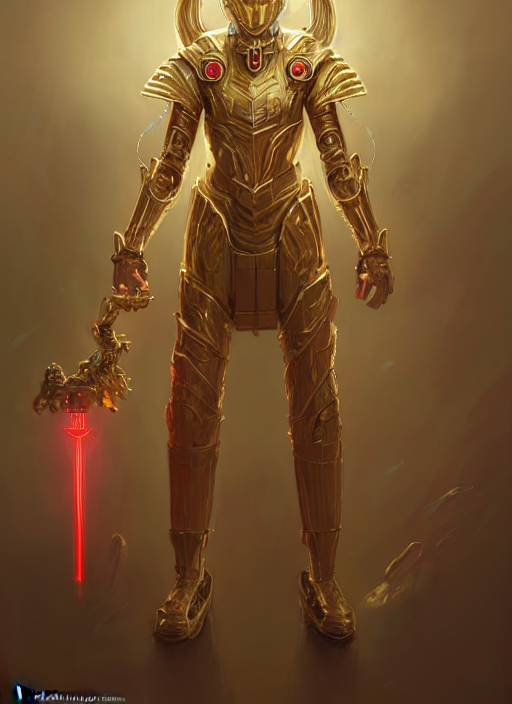

In [22]:
def DeforumArgs():
    #@markdown **Save & Display Settings**
    batch_name = "StableFun" #@param {type:"string"}
    outdir = get_output_folder(output_path, batch_name)
    save_grid = False
    save_settings = True #@param {type:"boolean"}
    save_samples = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}

    #@markdown **Image Settings**
    n_samples = 1 #@param
    W = 512 #@param
    H = 704 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.01 #@param {type:"number"}
    init_image = "/content/drive/MyDrive/AI/StableDiffusion/2022-08/StableFun/20220827221724_00000_5129993211.png" #@param {type:"string"}

    #@markdown **Sampling Settings**
    seed = 429496729 #@param
    sampler = 'klms' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim"]
    steps = 50 #@param
    scale = 13 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    seed_behavior = "fixed" #@param ["iter","fixed","random"]

    precision = 'autocast' 
    fixed_code = True
    C = 4
    f = 8

    prompt = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_c = None

    return locals()

def next_seed(args):
    if args.seed_behavior == 'iter':
        args.seed += 1
    elif args.seed_behavior == 'fixed':
        pass # always keep seed the same
    else:
        args.seed = random.randint(0, 2**32)
    return args.seed


args = SimpleNamespace(**DeforumArgs())
args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

if args.seed == -1:
    args.seed = random.randint(0, 2**32)
if anim_args.animation_mode == 'Video Input':
    args.use_init = True
if not args.use_init:
    args.init_image = None
    args.strength = 0
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

def render_image_batch(args):
    args.prompts = prompts
    
    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    if args.save_settings or args.save_samples:
        print(f"Saving to {os.path.join(args.outdir, args.timestring)}_*")

    # save settings for the batch
    if args.save_settings:
        filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
        with open(filename, "w+", encoding="utf-8") as f:
            json.dump(dict(args.__dict__), f, ensure_ascii=False, indent=4)

    index = 0
    
    # function for init image batching
    init_array = []
    if args.use_init:
        if args.init_image == "":
            raise FileNotFoundError("No path was given for init_image")
        if args.init_image.startswith('http://') or args.init_image.startswith('https://'):
            init_array.append(args.init_image)
        elif not os.path.isfile(args.init_image):
            if args.init_image[-1] != "/": # avoids path error by adding / to end if not there
                args.init_image += "/" 
            for image in sorted(os.listdir(args.init_image)): # iterates dir and appends images to init_array
                if image.split(".")[-1] in ("png", "jpg", "jpeg"):
                    init_array.append(args.init_image + image)
        else:
            init_array.append(args.init_image)
    else:
        init_array = [""] 

    for batch_index in range(args.n_batch):
        print(f"Batch {batch_index+1} of {args.n_batch}")
        
        for image in init_array: # iterates the init images
            args.init_image = image
            for prompt in prompts:
                args.prompt = process_noodle_soup(prompt)
                print('Generate', args.prompt)
                results = generate(args)
                for image in results:
                    if args.save_samples:
                        filename = f"{args.timestring}_{index:05}_{args.seed}.png"
                        image.save(os.path.join(args.outdir, filename))
                    if args.display_samples:
                        display.display(image)
                    index += 1
                args.seed = next_seed(args)


def render_animation(args, anim_args):
    # animations use key framed prompts
    args.prompts = animation_prompts

    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    print(f"Saving animation frames to {args.outdir}")

    # save settings for the batch
    settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
    with open(settings_filename, "w+", encoding="utf-8") as f:
        s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
        json.dump(s, f, ensure_ascii=False, indent=4)

    # expand prompts out to per-frame
    prompt_series = pd.Series([np.nan for a in range(anim_args.max_frames)])
    for i, prompt in animation_prompts.items():
        prompt_series[i] = prompt
    prompt_series = prompt_series.ffill().bfill()

    # check for video inits
    using_vid_init = anim_args.animation_mode == 'Video Input'

    args.n_samples = 1
    prev_sample = None
    color_match_sample = None
    for frame_idx in range(anim_args.max_frames):
        print(f"Rendering animation frame {frame_idx} of {anim_args.max_frames}")

        # apply transforms to previous frame
        if prev_sample is not None:
            if anim_args.key_frames:
                angle = angle_series[frame_idx]
                zoom = zoom_series[frame_idx]
                translation_x = translation_x_series[frame_idx]
                translation_y = translation_y_series[frame_idx]
                print(
                    f'angle: {angle}',
                    f'zoom: {zoom}',
                    f'translation_x: {translation_x}',
                    f'translation_y: {translation_y}',
                )
            xform = make_xform_2d(args.W, args.H, translation_x, translation_y, angle, zoom)

            # transform previous frame
            prev_img = sample_to_cv2(prev_sample)
            prev_img = cv2.warpPerspective(
                prev_img,
                xform,
                (prev_img.shape[1], prev_img.shape[0]),
                borderMode=cv2.BORDER_WRAP if anim_args.border == 'wrap' else cv2.BORDER_REPLICATE
            )

            # apply color matching
            if anim_args.color_coherence == 'MatchFrame0':
                if color_match_sample is None:
                    color_match_sample = prev_img.copy()
                else:
                    prev_img = maintain_colors(prev_img, color_match_sample, (frame_idx%2) == 0)

            # apply frame noising
            noised_sample = add_noise(sample_from_cv2(prev_img), anim_args.previous_frame_noise)

            # use transformed previous frame as init for current
            args.use_init = True
            args.init_sample = noised_sample.half().to(device)
            args.strength = max(0.0, min(1.0, anim_args.previous_frame_strength))

        # grab prompt for current frame
        args.prompt = prompt_series[frame_idx]
        print(f"{args.prompt} {args.seed}")

        # grab init image for current frame
        if using_vid_init:
            init_frame = os.path.join(args.outdir, 'inputframes', f"{frame_idx+1:04}.jpg")            
            print(f"Using video init frame {init_frame}")
            args.init_image = init_frame

        # sample the diffusion model
        results = generate(args, return_latent=False, return_sample=True)
        sample, image = results[0], results[1]
    
        filename = f"{args.timestring}_{frame_idx:05}.png"
        image.save(os.path.join(args.outdir, filename))
        if not using_vid_init:
            prev_sample = sample
        
        display.clear_output(wait=True)
        display.display(image)

        args.seed = next_seed(args)

def render_input_video(args, anim_args):
    # create a folder for the video input frames to live in
    video_in_frame_path = os.path.join(args.outdir, 'inputframes') 
    os.makedirs(os.path.join(args.outdir, video_in_frame_path), exist_ok=True)
    
    # save the video frames from input video
    print(f"Exporting Video Frames (1 every {anim_args.extract_nth_frame}) frames to {video_in_frame_path}...")
    try:
        for f in pathlib.Path(video_in_frame_path).glob('*.jpg'):
            f.unlink()
    except:
        pass
    vf = f'select=not(mod(n\,{anim_args.extract_nth_frame}))'
    subprocess.run([
        'ffmpeg', '-i', f'{anim_args.video_init_path}', 
        '-vf', f'{vf}', '-vsync', 'vfr', '-q:v', '2', 
        '-loglevel', 'error', '-stats',  
        os.path.join(video_in_frame_path, '%04d.jpg')
    ], stdout=subprocess.PIPE).stdout.decode('utf-8')

    # determine max frames from length of input frames
    anim_args.max_frames = len([f for f in pathlib.Path(video_in_frame_path).glob('*.jpg')])

    args.use_init = True
    print(f"Loading {anim_args.max_frames} input frames from {video_in_frame_path} and saving video frames to {args.outdir}")
    render_animation(args, anim_args)

def render_interpolation(args, anim_args):
    # animations use key framed prompts
    args.prompts = animation_prompts

    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    print(f"Saving animation frames to {args.outdir}")

    # save settings for the batch
    settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
    with open(settings_filename, "w+", encoding="utf-8") as f:
        s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
        json.dump(s, f, ensure_ascii=False, indent=4)
    
    # Interpolation Settings
    args.n_samples = 1
    args.seed_behavior = 'fixed' # force fix seed at the moment bc only 1 seed is available
    prompts_c_s = [] # cache all the text embeddings

    print(f"Preparing for interpolation of the following...")

    for i, prompt in animation_prompts.items():
      args.prompt = prompt

      # sample the diffusion model
      results = generate(args, return_c=True)
      c, image = results[0], results[1]
      prompts_c_s.append(c) 
      
      # display.clear_output(wait=True)
      display.display(image)
      
      args.seed = next_seed(args)

    display.clear_output(wait=True)
    print(f"Interpolation start...")

    frame_idx = 0

    for i in range(len(prompts_c_s)-1):
      for j in range(anim_args.interpolate_x_frames+1):
        # interpolate the text embedding
        prompt1_c = prompts_c_s[i]
        prompt2_c = prompts_c_s[i+1]  
        args.init_c = prompt1_c.add(prompt2_c.sub(prompt1_c).mul(j * 1/(anim_args.interpolate_x_frames+1)))

        # sample the diffusion model
        results = generate(args)
        image = results[0]

        filename = f"{args.timestring}_{frame_idx:05}.png"
        image.save(os.path.join(args.outdir, filename))
        frame_idx += 1

        display.clear_output(wait=True)
        display.display(image)

        args.seed = next_seed(args)

    # generate the last prompt
    args.init_c = prompts_c_s[-1]
    results = generate(args)
    image = results[0]
    filename = f"{args.timestring}_{frame_idx:05}.png"
    image.save(os.path.join(args.outdir, filename))

    display.clear_output(wait=True)
    display.display(image)
    args.seed = next_seed(args)

    #clear init_c
    args.init_c = None

if anim_args.animation_mode == '2D':
    render_animation(args, anim_args)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(args, anim_args)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(args, anim_args)
else:
    render_image_batch(args)    

# Create video from frames

In [ ]:
skip_video_for_run_all = True #@param {type: 'boolean'}
fps = 12#@param {type:"number"}

if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:
    import subprocess
    from base64 import b64encode

    image_path = os.path.join(args.outdir, f"{args.timestring}_%05d.png")
    mp4_path = os.path.join(args.outdir, f"{args.timestring}.mp4")

    print(f"{image_path} -> {mp4_path}")

    # make video
    cmd = [
        'ffmpeg',
        '-y',
        '-vcodec', 'png',
        '-r', str(fps),
        '-start_number', str(0),
        '-i', image_path,
        '-frames:v', str(anim_args.max_frames),
        '-c:v', 'libx264',
        '-vf',
        f'fps={fps}',
        '-pix_fmt', 'yuv420p',
        '-crf', '17',
        '-preset', 'veryfast',
        mp4_path
    ]
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        raise RuntimeError(stderr)

    mp4 = open(mp4_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display( display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>') )